**Name:** Muhammad Umer

**Email** umerhayat282@gmail.com

**Date** October 29, 2025

____

##  **About this Notebook:**


This notebook focuses on predicting house prices using advanced ensemble learning techniques — XGBoost, LightGBM, and CatBoost. The dataset is preprocessed through a customized ColumnTransformer pipeline, where numerical features are scaled using RobustScaler and StandardScaler, and categorical features are encoded with OneHotEncoder. After splitting the data into training and testing sets, each model is trained and evaluated using key regression metrics such as R² Score, Mean Absolute Error (MAE), and Root Mean Squared Error (RMSE). The results are then visualized to compare model performance and understand prediction accuracy. This end-to-end workflow demonstrates how modern gradient boosting algorithms can be effectively combined with preprocessing pipelines to achieve high-accuracy regression models for structured data.

In [45]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

import warnings
warnings.filterwarnings("ignore")

In [46]:
df = pd.read_csv("D:\\Ai_machine_learning_deep_learning_air_university_lab_islamabad\\data\\HousingData.csv")

In [47]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,NaN,36.2


##  **Metadata**

| Column      | Meaning                                                               |
| ----------- | --------------------------------------------------------------------- |
| **CRIM**    | Per capita crime rate by town                                         |
| **ZN**      | Proportion of residential land zoned for lots over 25,000 sq.ft.      |
| **INDUS**   | Proportion of non-retail business acres per town                      |
| **CHAS**    | Charles River dummy variable (= 1 if tract bounds river; 0 otherwise) |
| **NOX**     | Nitric oxides concentration (parts per 10 million)                    |
| **RM**      | Average number of rooms per dwelling                                  |
| **AGE**     | Proportion of owner-occupied units built before 1940                  |
| **DIS**     | Weighted distances to five Boston employment centers                  |
| **RAD**     | Index of accessibility to radial highways                             |
| **TAX**     | Full-value property-tax rate per $10,000                              |
| **PTRATIO** | Pupil–teacher ratio by town                                           |
| **B**       | 1000(Bk - 0.63)² where Bk is the proportion of Black residents        |
| **LSTAT**   | % lower status of the population                                      |
| **MEDV**    | Median value of owner-occupied homes in $1000s                        |


In [48]:
df.isnull().sum()

CRIM       20
ZN         20
INDUS      20
CHAS       20
NOX         0
RM          0
AGE        20
DIS         0
RAD         0
TAX         0
PTRATIO     0
B           0
LSTAT      20
MEDV        0
dtype: int64

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     486 non-null    float64
 1   ZN       486 non-null    float64
 2   INDUS    486 non-null    float64
 3   CHAS     486 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      486 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    int64  
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    486 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB


In [50]:

df = df.dropna(subset=["MEDV"])  

X = df.drop("MEDV", axis=1)
y = df["MEDV"]

In [51]:
categorical_cols = ["CHAS", "RAD"]
robust_cols = ["CRIM", "LSTAT"]
standard_cols = ["ZN", "INDUS", "NOX", "RM", "AGE", "DIS", "TAX", "PTRATIO", "B"]

In [52]:
preprocessor = ColumnTransformer(transformers=[
    ("robust", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", RobustScaler())
    ]), robust_cols),

    ("standard", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]), standard_cols),

    ("categorical", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown="ignore"))
    ]), categorical_cols)
])

In [53]:
models = {
    "XGBoost": XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
        objective="reg:squarederror"
    ),
    "LightGBM": LGBMRegressor(
        num_leaves=31,
        max_depth=-1,
        min_data_in_leaf=5,
        min_gain_to_split=0.0,
        reg_alpha=0.0,
        reg_lambda=0.0,
        learning_rate=0.05,
        n_estimators=1000,
        subsample=0.8,
        colsample_bytree=0.8
    ),
    "CatBoost": CatBoostRegressor(
        iterations=500,
        learning_rate=0.05,
        depth=6,
        verbose=0,
        random_seed=42
    )
}


In [54]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [55]:
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep  = preprocessor.transform(X_test)

# Then train models directly
for name, model in models.items():
    model.fit(X_train_prep, y_train)
    preds = model.predict(X_test_prep)

    r2 = r2_score(y_test, preds)
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))

    print(f"{name}: R2={r2:.4f}, MAE={mae:.3f}, RMSE={rmse:.3f}")

XGBoost: R2=0.9127, MAE=1.902, RMSE=2.530
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_gain_to_split is set=0.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_gain_to_split is set=0.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000334 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 973
[LightGBM] [Info] Number of data points in the train set: 404, number of used features: 22
[LightGBM] [Info] Start training from score 22.796535
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM]

In [56]:
results = {}
preds_dict = {}

for name, model in models.items():
    preds = model.predict(X_test_prep)
    preds_dict[name] = preds
    r2 = r2_score(y_test, preds)
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    results[name] = {"R2": r2, "MAE": mae, "RMSE": rmse}

[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_gain_to_split is set=0.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0


In [57]:
df_results = pd.DataFrame(results).T

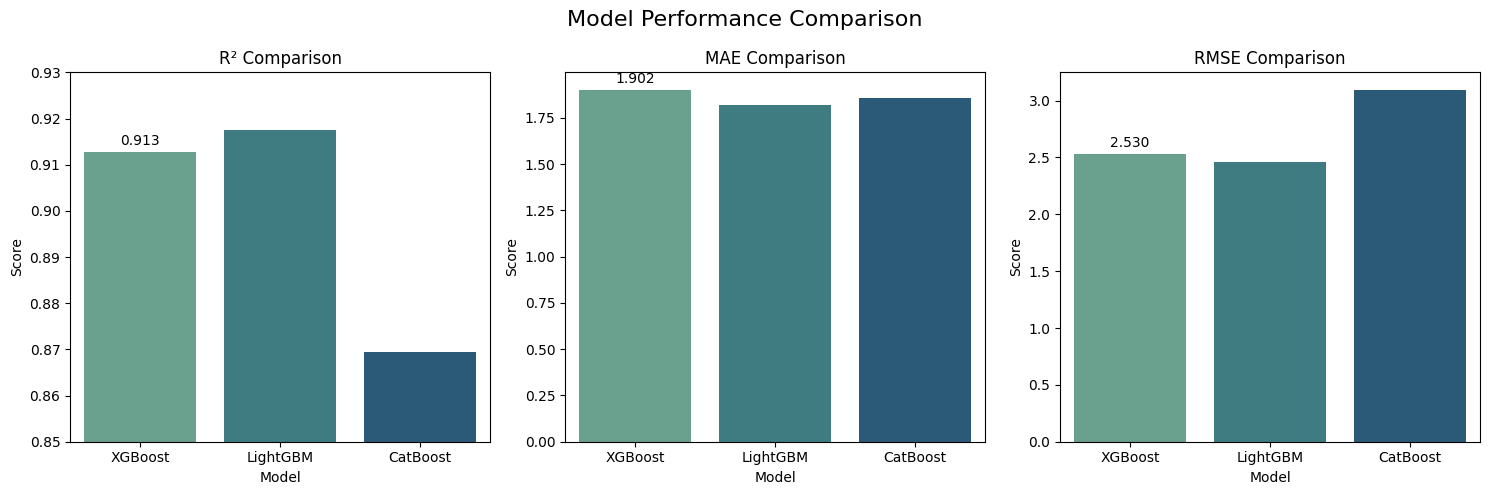

In [58]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.barplot(x=df_results.index, y='R2', data=df_results, ax=axes[0], palette='crest')
axes[0].set_title("R² Comparison")
axes[0].set_ylim(0.85, 0.93)

sns.barplot(x=df_results.index, y='MAE', data=df_results, ax=axes[1], palette='crest')
axes[1].set_title("MAE Comparison")

sns.barplot(x=df_results.index, y='RMSE', data=df_results, ax=axes[2], palette='crest')
axes[2].set_title("RMSE Comparison")

for ax in axes:
    ax.bar_label(ax.containers[0], fmt="%.3f", label_type="edge", padding=3)
    ax.set_xlabel("Model")
    ax.set_ylabel("Score")

plt.suptitle("Model Performance Comparison", fontsize=16)
plt.tight_layout()
plt.show()

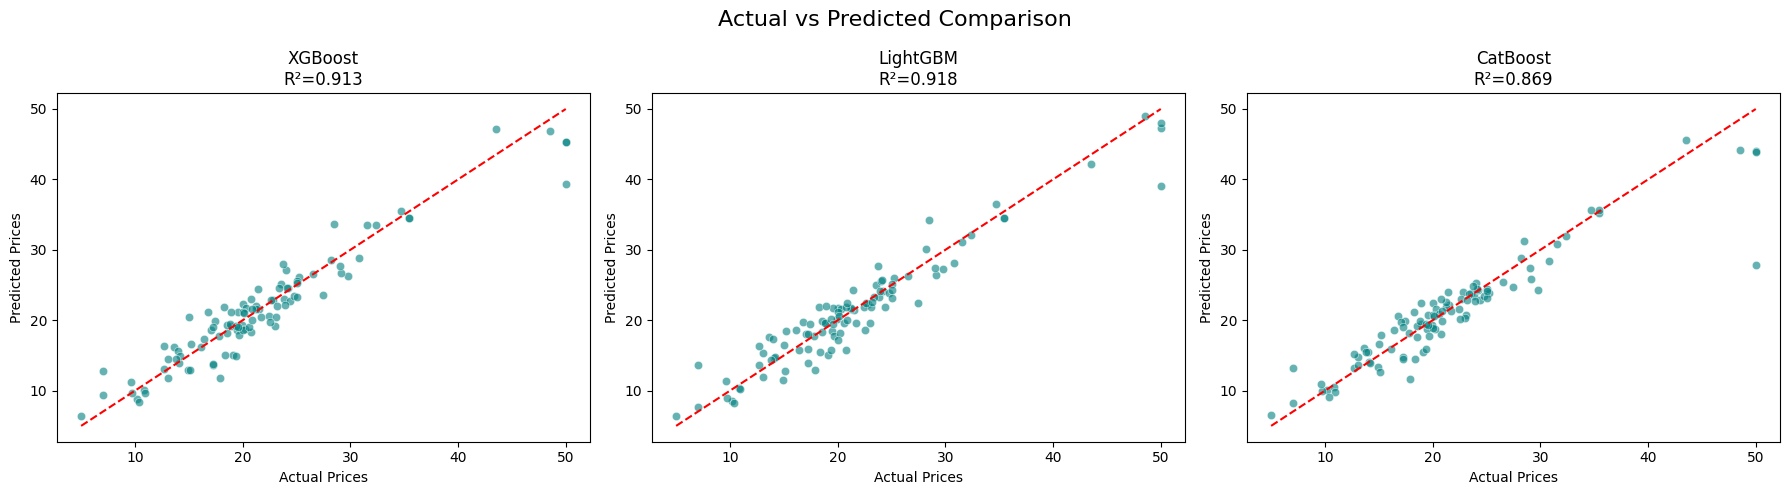

In [59]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5))
for i, (name, preds) in enumerate(preds_dict.items()):
    sns.scatterplot(x=y_test, y=preds, ax=ax[i], alpha=0.6, color='teal')
    ax[i].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    ax[i].set_title(f"{name}\nR²={results[name]['R2']:.3f}")
    ax[i].set_xlabel("Actual Prices")
    ax[i].set_ylabel("Predicted Prices")

plt.suptitle("Actual vs Predicted Comparison", fontsize=16)
plt.tight_layout()
plt.show()

##  **Summary & Conclusion**

In this project, three powerful gradient boosting models — XGBoost, LightGBM, and CatBoost — were trained and evaluated to predict house prices using a well-structured preprocessing pipeline. Based on the evaluation metrics, all three models performed strongly, showing high predictive accuracy and generalization capability.


| Model        | R²            | MAE       | RMSE      | Remarks                                    |
| ------------ | ------------- | --------- | --------- | ------------------------------------------ |
| **XGBoost**  | 0.9127        | 1.902     | 2.530     | Excellent overall fit                      |
| **LightGBM** | 🥇 **0.9175** | **1.817** | **2.460** | **Best model — most accurate & efficient** |
| **CatBoost** | 0.8695        | 1.857     | 3.094     | Slightly less accurate, may need tuning    |


___